In [1]:
# Download and setup Flowers-102 dataset
import os
import urllib.request
import scipy.io
from zipfile import ZipFile
import shutil

def download_flowers102_dataset(data_dir='data/flowers-102'):
    """
    Download and extract the Flowers-102 dataset
    """
    # Create data directory if it doesn't exist
    os.makedirs(data_dir, exist_ok=True)

    # Check if dataset already exists
    if os.path.exists(os.path.join(data_dir, 'imagelabels.mat')) and \
       os.path.exists(os.path.join(data_dir, 'setid.mat')) and \
       os.path.exists(os.path.join(data_dir, 'jpg')):
        print("✓ Flowers-102 dataset already downloaded and extracted!")
        return

    print("Downloading Flowers-102 dataset...")

    # URLs for the dataset files
    urls = {
        'images': 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz',
        'labels': 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
        'setid': 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
    }

    # Download image labels
    labels_path = os.path.join(data_dir, 'imagelabels.mat')
    if not os.path.exists(labels_path):
        print("  Downloading imagelabels.mat...")
        try:
            urllib.request.urlretrieve(urls['labels'], labels_path)
            print("  ✓ imagelabels.mat downloaded")
        except Exception as e:
            print(f"  ✗ Failed to download imagelabels.mat: {e}")
            return False

    # Download setid
    setid_path = os.path.join(data_dir, 'setid.mat')
    if not os.path.exists(setid_path):
        print("  Downloading setid.mat...")
        try:
            urllib.request.urlretrieve(urls['setid'], setid_path)
            print("  ✓ setid.mat downloaded")
        except Exception as e:
            print(f"  ✗ Failed to download setid.mat: {e}")
            return False

    # Download and extract images
    jpg_dir = os.path.join(data_dir, 'jpg')
    if not os.path.exists(jpg_dir):
        print("  Downloading images (this may take a few minutes)...")
        tar_path = os.path.join(data_dir, 'flowers.tgz')
        try:
            urllib.request.urlretrieve(urls['images'], tar_path)
            print("  ✓ Images downloaded, extracting...")

            import tarfile
            with tarfile.open(tar_path, 'r:gz') as tar:
                tar.extractall(data_dir)

            # Move images to jpg folder if needed
            temp_dir = os.path.join(data_dir, 'jpg')
            if not os.path.exists(temp_dir):
                os.makedirs(temp_dir)

            # Look for extracted jpg directory
            for root, dirs, files in os.walk(data_dir):
                if 'jpg' in root:
                    for file in files:
                        if file.endswith('.jpg'):
                            src = os.path.join(root, file)
                            dst = os.path.join(jpg_dir, file)
                            if not os.path.exists(dst):
                                shutil.copy2(src, dst)

            # Clean up tar file
            if os.path.exists(tar_path):
                os.remove(tar_path)

            print("  ✓ Images extracted")
        except Exception as e:
            print(f"  ✗ Failed to download images: {e}")
            return False

    print("✓ Flowers-102 dataset ready!")
    return True

# Download the dataset
download_flowers102_dataset()


  ✓ imagelabels.mat downloaded
  ✓ setid.mat downloaded
  ✓ Images downloaded, extracting...


/tmp/ipython-input-396053014.py:64: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_dir)


  ✓ Images extracted
✓ Flowers-102 dataset ready!


True

# Flower Recognition with ResNet

In [ ]:
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy


In [2]:
# Flower Recognition with ResNet - Complete Implementation
# Installing required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda:0


In [3]:
# Set up data loading and preprocessing
import os
import scipy.io
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data directories
data_dir = 'data/flowers-102'
images_dir = os.path.join(data_dir, 'jpg')

# Load mat files for labels and train/val/test splits
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0] - 1  # Convert to 0-based indexing
splits = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))

# Get indices for train, val, and test sets
train_idx = splits['trnid'][0] - 1  # Convert to 0-based indexing
val_idx = splits['valid'][0] - 1
test_idx = splits['tstid'][0] - 1

class Flowers102Dataset(Dataset):
    def __init__(self, image_dir, indices, labels, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_name = f'image_{img_idx+1:05d}.jpg'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[img_idx]
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = Flowers102Dataset(images_dir, train_idx, labels, train_transform)
val_dataset = Flowers102Dataset(images_dir, val_idx, labels, val_test_transform)
test_dataset = Flowers102Dataset(images_dir, test_idx, labels, val_test_transform)

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# Store dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Dataset sizes:")
print(f"Training: {dataset_sizes['train']} images")
print(f"Validation: {dataset_sizes['val']} images")
print(f"Test: {dataset_sizes['test']} images")

Dataset sizes:
Training: 1020 images
Validation: 1020 images
Test: 6149 images


Training samples:


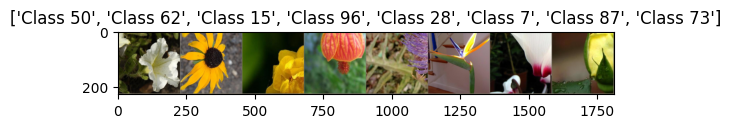

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Visualize some training images
def visualize_samples(dataloader, num_images=8):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[f'Class {x}' for x in classes[:num_images]])

print("Training samples:")
visualize_samples(dataloaders['train'])

In [5]:
# Base ResNet Model
class FlowerResNet(nn.Module):
    def __init__(self, base_model='resnet18', pretrained=True, num_classes=102):
        super(FlowerResNet, self).__init__()

        if base_model == 'resnet18':
            if pretrained:
                self.backbone = models.resnet18(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet18(weights=None)
        elif base_model == 'resnet34':
            if pretrained:
                self.backbone = models.resnet34(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet34(weights=None)
        else:
            raise ValueError("Unsupported base model")

        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Model with Frozen Stages
class FlowerResNetFrozen(nn.Module):
    def __init__(self, base_model='resnet18', num_frozen_stages=3, num_classes=102):
        super(FlowerResNetFrozen, self).__init__()

        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        elif base_model == 'resnet34':
            self.backbone = models.resnet34(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Unsupported base model")

        # Freeze specified stages
        self._freeze_stages(num_frozen_stages)

        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def _freeze_stages(self, num_stages):
        """Freeze the first num_stages of ResNet"""
        if num_stages >= 1:
            for param in self.backbone.conv1.parameters():
                param.requires_grad = False
            for param in self.backbone.bn1.parameters():
                param.requires_grad = False
        if num_stages >= 2:
            for param in self.backbone.layer1.parameters():
                param.requires_grad = False
        if num_stages >= 3:
            for param in self.backbone.layer2.parameters():
                param.requires_grad = False
        if num_stages >= 4:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        if num_stages >= 5:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='resnet18'):
    since = time.time()

    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')

    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)

    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_losses, train_accs, val_losses, val_accs

In [7]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                # Color code correct/incorrect predictions
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')

                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()

    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

### Experiment 3 resnet-34 with 3 frozen stages

ResNet34 - Trainable parameters: 19989094/21336998 (93.68%)
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, Loss=4.4727, Acc=0.0357]


train Loss: 4.6625 Acc: 0.0186


Val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=4.0953, Acc=0.0357]


val Loss: 4.3069 Acc: 0.0696
New best model saved with val_acc: 0.0696

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s, Loss=3.8795, Acc=0.2500]


train Loss: 4.0874 Acc: 0.1598


Val Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=3.2192, Acc=0.4643]


val Loss: 3.6968 Acc: 0.3029
New best model saved with val_acc: 0.3029

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s, Loss=3.1557, Acc=0.6071]


train Loss: 3.5180 Acc: 0.4186


Val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=2.2952, Acc=0.7500]


val Loss: 3.0534 Acc: 0.5137
New best model saved with val_acc: 0.5137

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s, Loss=3.0866, Acc=0.5357]


train Loss: 2.9559 Acc: 0.5647


Val Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s, Loss=1.7425, Acc=0.7500]


val Loss: 2.5210 Acc: 0.6265
New best model saved with val_acc: 0.6265

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s, Loss=2.0937, Acc=0.7143]


train Loss: 2.4865 Acc: 0.6735


Val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, Loss=1.4396, Acc=0.7500]


val Loss: 2.1024 Acc: 0.6961
New best model saved with val_acc: 0.6961

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, Loss=2.0720, Acc=0.8214]


train Loss: 2.1087 Acc: 0.7480


Val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s, Loss=1.2450, Acc=0.7857]


val Loss: 1.7625 Acc: 0.7500
New best model saved with val_acc: 0.7500

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s, Loss=1.9261, Acc=0.7143]


train Loss: 1.7669 Acc: 0.8088


Val Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=0.9077, Acc=0.8571]


val Loss: 1.5038 Acc: 0.7912
New best model saved with val_acc: 0.7912

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=1.2139, Acc=0.8214]


train Loss: 1.5582 Acc: 0.8147


Val Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.7926, Acc=0.8929]


val Loss: 1.3070 Acc: 0.8245
New best model saved with val_acc: 0.8245

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=1.2412, Acc=0.8214]


train Loss: 1.2922 Acc: 0.8696


Val Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s, Loss=0.6934, Acc=0.8571]


val Loss: 1.1334 Acc: 0.8382
New best model saved with val_acc: 0.8382

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, Loss=1.1011, Acc=0.9643]


train Loss: 1.1276 Acc: 0.8882


Val Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s, Loss=0.6322, Acc=0.9643]


val Loss: 0.9985 Acc: 0.8510
New best model saved with val_acc: 0.8510

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=1.0818, Acc=0.8929]


train Loss: 0.9713 Acc: 0.8931


Val Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s, Loss=0.5471, Acc=0.9286]


val Loss: 0.8997 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, Loss=1.1302, Acc=0.8571]


train Loss: 0.8686 Acc: 0.9020


Val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s, Loss=0.5589, Acc=0.8929]


val Loss: 0.8087 Acc: 0.8843
New best model saved with val_acc: 0.8843

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, Loss=1.0327, Acc=0.8571]


train Loss: 0.7603 Acc: 0.9176


Val Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, Loss=0.4465, Acc=0.9643]


val Loss: 0.7529 Acc: 0.8902
New best model saved with val_acc: 0.8902

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s, Loss=0.7732, Acc=0.9286]


train Loss: 0.6669 Acc: 0.9314


Val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.4774, Acc=0.8929]


val Loss: 0.7071 Acc: 0.8931
New best model saved with val_acc: 0.8931

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, Loss=0.6058, Acc=0.9286]


train Loss: 0.6362 Acc: 0.9255


Val Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, Loss=0.3901, Acc=0.9643]


val Loss: 0.6441 Acc: 0.8961
New best model saved with val_acc: 0.8961

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, Loss=0.5201, Acc=0.9643]


train Loss: 0.5485 Acc: 0.9451


Val Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, Loss=0.3461, Acc=1.0000]


val Loss: 0.6136 Acc: 0.8990
New best model saved with val_acc: 0.8990

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.6210, Acc=0.9286]


train Loss: 0.5310 Acc: 0.9480


Val Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=0.3495, Acc=0.9643]


val Loss: 0.5923 Acc: 0.8961

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, Loss=0.3993, Acc=0.9286]


train Loss: 0.4779 Acc: 0.9539


Val Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=0.3264, Acc=0.9643]


val Loss: 0.5585 Acc: 0.9020
New best model saved with val_acc: 0.9020

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, Loss=0.6177, Acc=0.8571]


train Loss: 0.4689 Acc: 0.9461


Val Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s, Loss=0.3491, Acc=0.9286]


val Loss: 0.5283 Acc: 0.9059
New best model saved with val_acc: 0.9059

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, Loss=0.2287, Acc=1.0000]


train Loss: 0.4345 Acc: 0.9549


Val Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s, Loss=0.3035, Acc=0.9643]


val Loss: 0.5155 Acc: 0.9078
New best model saved with val_acc: 0.9078

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=0.5128, Acc=0.9286]


train Loss: 0.3944 Acc: 0.9490


Val Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s, Loss=0.3128, Acc=0.9643]


val Loss: 0.4974 Acc: 0.9098
New best model saved with val_acc: 0.9098

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, Loss=0.3738, Acc=0.9286]


train Loss: 0.3441 Acc: 0.9618


Val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2655, Acc=1.0000]


val Loss: 0.4785 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, Loss=0.3802, Acc=1.0000]


train Loss: 0.3425 Acc: 0.9657


Val Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, Loss=0.2715, Acc=0.9643]


val Loss: 0.4626 Acc: 0.9176
New best model saved with val_acc: 0.9176

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, Loss=0.3033, Acc=0.9286]


train Loss: 0.3083 Acc: 0.9637


Val Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, Loss=0.2662, Acc=0.9643]


val Loss: 0.4585 Acc: 0.9196
New best model saved with val_acc: 0.9196

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.3752, Acc=1.0000]


train Loss: 0.3024 Acc: 0.9696


Val Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.1932, Acc=1.0000]


val Loss: 0.4517 Acc: 0.9206
New best model saved with val_acc: 0.9206

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s, Loss=0.2288, Acc=0.9643]


train Loss: 0.3034 Acc: 0.9657


Val Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, Loss=0.2040, Acc=1.0000]


val Loss: 0.4319 Acc: 0.9176

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, Loss=0.1524, Acc=0.9643]


train Loss: 0.2874 Acc: 0.9598


Val Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=0.2403, Acc=0.9643]


val Loss: 0.4241 Acc: 0.9225
New best model saved with val_acc: 0.9225

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, Loss=0.2891, Acc=0.9643]


train Loss: 0.3086 Acc: 0.9529


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s, Loss=0.2276, Acc=0.9643]


val Loss: 0.4135 Acc: 0.9206

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, Loss=0.1727, Acc=1.0000]


train Loss: 0.2658 Acc: 0.9667


Val Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, Loss=0.1827, Acc=1.0000]


val Loss: 0.4166 Acc: 0.9216

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, Loss=0.1257, Acc=1.0000]


train Loss: 0.2332 Acc: 0.9696


Val Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.1793, Acc=1.0000]


val Loss: 0.4060 Acc: 0.9265
New best model saved with val_acc: 0.9265

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s, Loss=0.2406, Acc=0.9643]


train Loss: 0.2536 Acc: 0.9696


Val Epoch 30: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, Loss=0.1965, Acc=1.0000]


val Loss: 0.4048 Acc: 0.9275
New best model saved with val_acc: 0.9275

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s, Loss=0.2212, Acc=0.9643]


train Loss: 0.2327 Acc: 0.9755


Val Epoch 31: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s, Loss=0.2025, Acc=1.0000]


val Loss: 0.3979 Acc: 0.9294
New best model saved with val_acc: 0.9294

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s, Loss=0.3662, Acc=0.8929]


train Loss: 0.2236 Acc: 0.9735


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, Loss=0.1980, Acc=1.0000]


val Loss: 0.3983 Acc: 0.9294

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s, Loss=0.3659, Acc=0.9643]


train Loss: 0.2367 Acc: 0.9735


Val Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.1953, Acc=1.0000]


val Loss: 0.4009 Acc: 0.9314
New best model saved with val_acc: 0.9314

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s, Loss=0.4175, Acc=0.8929]


train Loss: 0.2263 Acc: 0.9755


Val Epoch 34: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s, Loss=0.2100, Acc=1.0000]


val Loss: 0.3932 Acc: 0.9304

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.1859, Acc=0.9643]


train Loss: 0.2238 Acc: 0.9696


Val Epoch 35: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.1918, Acc=1.0000]


val Loss: 0.3992 Acc: 0.9255

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, Loss=0.2449, Acc=0.9643]


train Loss: 0.2051 Acc: 0.9755


Val Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2074, Acc=1.0000]


val Loss: 0.3900 Acc: 0.9284

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Loss=0.2626, Acc=0.9643]


train Loss: 0.2534 Acc: 0.9598


Val Epoch 37: 100%|██████████| 32/32 [00:06<00:00,  4.98it/s, Loss=0.2157, Acc=1.0000]


val Loss: 0.3931 Acc: 0.9304

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, Loss=0.2207, Acc=0.9643]


train Loss: 0.2133 Acc: 0.9735


Val Epoch 38: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, Loss=0.1943, Acc=1.0000]


val Loss: 0.3916 Acc: 0.9294

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, Loss=0.2477, Acc=0.9643]


train Loss: 0.1989 Acc: 0.9755


Val Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s, Loss=0.2238, Acc=1.0000]


val Loss: 0.3931 Acc: 0.9324
New best model saved with val_acc: 0.9324

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, Loss=0.2183, Acc=0.9643]


train Loss: 0.2144 Acc: 0.9765


Val Epoch 40: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.2042, Acc=1.0000]


val Loss: 0.3962 Acc: 0.9245

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s, Loss=0.1009, Acc=1.0000]


train Loss: 0.2289 Acc: 0.9725


Val Epoch 41: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s, Loss=0.1903, Acc=1.0000]


val Loss: 0.3923 Acc: 0.9284

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, Loss=0.1212, Acc=1.0000]


train Loss: 0.2223 Acc: 0.9735


Val Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, Loss=0.1807, Acc=1.0000]


val Loss: 0.3876 Acc: 0.9265

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s, Loss=0.2759, Acc=0.9643]


train Loss: 0.2363 Acc: 0.9696


Val Epoch 43: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.2204, Acc=0.9643]


val Loss: 0.3911 Acc: 0.9294

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, Loss=0.1357, Acc=1.0000]


train Loss: 0.2337 Acc: 0.9637


Val Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, Loss=0.2156, Acc=1.0000]


val Loss: 0.3903 Acc: 0.9304

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s, Loss=0.1317, Acc=1.0000]


train Loss: 0.1973 Acc: 0.9745


Val Epoch 45: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.2054, Acc=1.0000]


val Loss: 0.3931 Acc: 0.9245

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, Loss=0.2843, Acc=0.9643]


train Loss: 0.2261 Acc: 0.9686


Val Epoch 46: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, Loss=0.2165, Acc=0.9643]


val Loss: 0.3892 Acc: 0.9284

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, Loss=0.1072, Acc=1.0000]


train Loss: 0.1901 Acc: 0.9775


Val Epoch 47: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s, Loss=0.2177, Acc=0.9643]


val Loss: 0.3866 Acc: 0.9304

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, Loss=0.1368, Acc=1.0000]


train Loss: 0.2221 Acc: 0.9676


Val Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, Loss=0.2105, Acc=0.9643]


val Loss: 0.3918 Acc: 0.9284

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s, Loss=0.0963, Acc=1.0000]


train Loss: 0.2139 Acc: 0.9716


Val Epoch 49: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.2059, Acc=1.0000]


val Loss: 0.3867 Acc: 0.9304

Training complete in 9m 42s
Best val Acc: 0.932353


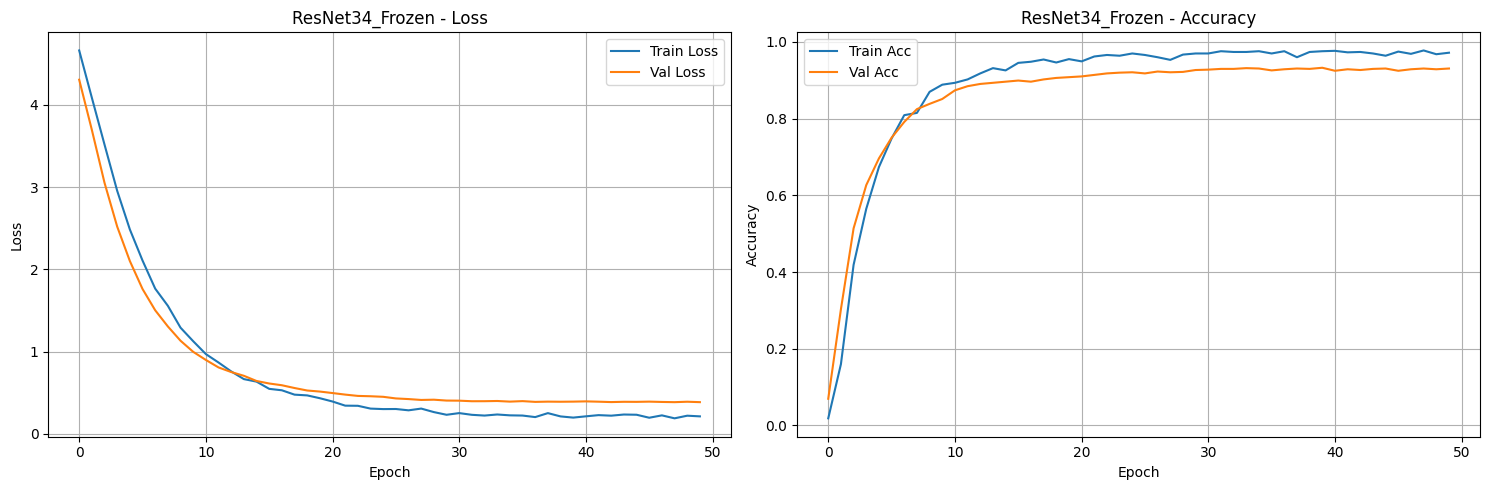

Evaluating on test set...


100%|██████████| 193/193 [00:34<00:00,  5.63it/s]


Test Loss: 0.4764
Test Accuracy: 0.9013
ResNet34 Frozen - Test Accuracy: 0.9013


In [22]:

# Create ResNet-34 model with frozen stages
model_resnet34 = FlowerResNetFrozen(base_model='resnet34', num_frozen_stages=3, num_classes=102)
model_resnet34 = model_resnet34.to(device)

# Count parameters
trainable_params_34 = sum(p.numel() for p in model_resnet34.parameters() if p.requires_grad)
total_params_34 = sum(p.numel() for p in model_resnet34.parameters())
print(f"ResNet34 - Trainable parameters: {trainable_params_34}/{total_params_34} ({trainable_params_34/total_params_34*100:.2f}%)")

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define number of epochs (if not already defined)
num_epochs = 50

# Define optimizer
optimizer_34 = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34.parameters()),
    lr=0.001, momentum=0.9
)
scheduler_34 = lr_scheduler.StepLR(optimizer_34, step_size=30, gamma=0.1)

# Train model
model_resnet34, train_losses_34, train_accs_34, val_losses_34, val_accs_34 = train_model(
    model_resnet34, criterion, optimizer_34, scheduler_34, num_epochs, 'resnet34_frozen'
)

# Plot results
plot_training_curves(train_losses_34, val_losses_34, train_accs_34, val_accs_34, 'ResNet34_Frozen')

# Evaluate on test set
test_loss_34, test_acc_34, all_preds_34, all_labels_34 = evaluate_model(model_resnet34, criterion)

# Save training logs
with open('resnet34_frozen.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_34[epoch]:.4f},{val_losses_34[epoch]:.4f},{train_accs_34[epoch]:.4f},{val_accs_34[epoch]:.4f}\n")

print(f"ResNet34 Frozen - Test Accuracy: {test_acc_34:.4f}")

----
## Improvement 1: MixUp Data Augmentation
Implement MixUp augmentation to improve model robustness through linear interpolation of image pairs and their labels.


MixUp augmentation applied during training
- Samples mixing coefficient λ from Beta distribution
- Creates random permutation of batch indices
- Mixes images: `mixed_inputs = λ * inputs + (1-λ) * inputs[index]`
- Mixes labels: `λ * loss(out, labels_a) + (1-λ) * loss(out, labels_b)`
- Applied with 50% probability to regularize training

In [12]:
def train_model_with_mixup(model, criterion, optimizer, scheduler, num_epochs=50, model_name='resnet_mixup', alpha=0.2):
    """
    Train model with MixUp augmentation

    Args:
        alpha: Beta distribution parameter for sampling λ
    """
    since = time.time()

    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')

    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)

    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # ===== MIXUP AUGMENTATION (lines 51-70) =====
                    if phase == 'train' and np.random.rand() > 0.5:  # Apply MixUp with 50% probability
                        # Sample mixing coefficient λ from Beta(α, α)
                        lam = np.random.beta(alpha, alpha)
                        lam = max(lam, 1 - lam)  # Make λ >= 0.5 for stability

                        # Create random permutation of indices
                        batch_size = inputs.size(0)
                        index = torch.randperm(batch_size).to(device)

                        # Mix inputs and labels
                        mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
                        labels_a = labels
                        labels_b = labels[index]

                        # Forward pass with mixed inputs
                        outputs = model(mixed_inputs)
                        _, preds = torch.max(outputs, 1)

                        # Compute MixUp loss: λ*loss(out, y_a) + (1-λ)*loss(out, y_b)
                        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                    else:
                        # Standard forward pass (no MixUp)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    # ===== END MIXUP AUGMENTATION =====

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_losses, train_accs, val_losses, val_accs



TRAINING RESNET-34 WITH MIXUP AUGMENTATION
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, Loss=4.3666, Acc=0.2687]


train Loss: 4.6902 Acc: 0.2687


Val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, Loss=3.9545, Acc=0.0784]


val Loss: 4.3189 Acc: 0.0784
New best model saved with val_acc: 0.0784

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, Loss=4.0196, Acc=1.3330]


train Loss: 4.1635 Acc: 1.3330


Val Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, Loss=3.0318, Acc=0.3147]


val Loss: 3.7393 Acc: 0.3147
New best model saved with val_acc: 0.3147

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, Loss=4.1508, Acc=5.2364]


train Loss: 3.6452 Acc: 5.2364


Val Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, Loss=2.2521, Acc=0.4863]


val Loss: 3.1373 Acc: 0.4863
New best model saved with val_acc: 0.4863

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, Loss=2.6416, Acc=7.0255]


train Loss: 3.2014 Acc: 7.0255


Val Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s, Loss=1.6283, Acc=0.6039]


val Loss: 2.6378 Acc: 0.6039
New best model saved with val_acc: 0.6039

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.19it/s, Loss=2.6771, Acc=10.3006]


train Loss: 2.7961 Acc: 10.3006


Val Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=1.4401, Acc=0.6882]


val Loss: 2.2475 Acc: 0.6882
New best model saved with val_acc: 0.6882

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, Loss=2.0542, Acc=10.1977]


train Loss: 2.3424 Acc: 10.1977


Val Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, Loss=1.1921, Acc=0.7422]


val Loss: 1.8799 Acc: 0.7422
New best model saved with val_acc: 0.7422

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, Loss=1.9821, Acc=9.7245]


train Loss: 2.1680 Acc: 9.7245


Val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, Loss=0.9235, Acc=0.7863]


val Loss: 1.6148 Acc: 0.7863
New best model saved with val_acc: 0.7863

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, Loss=1.8646, Acc=11.0008]


train Loss: 1.8954 Acc: 11.0008


Val Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.8172, Acc=0.8108]


val Loss: 1.4065 Acc: 0.8108
New best model saved with val_acc: 0.8108

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, Loss=1.4583, Acc=14.2886]


train Loss: 1.6053 Acc: 14.2886


Val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, Loss=0.6535, Acc=0.8324]


val Loss: 1.2357 Acc: 0.8324
New best model saved with val_acc: 0.8324

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, Loss=1.5141, Acc=13.0176]


train Loss: 1.3832 Acc: 13.0176


Val Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, Loss=0.6814, Acc=0.8480]


val Loss: 1.0902 Acc: 0.8480
New best model saved with val_acc: 0.8480

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s, Loss=0.9818, Acc=12.9790]


train Loss: 1.4000 Acc: 12.9790


Val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, Loss=0.6571, Acc=0.8510]


val Loss: 0.9909 Acc: 0.8510
New best model saved with val_acc: 0.8510

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, Loss=0.8520, Acc=12.4569]


train Loss: 1.1179 Acc: 12.4569


Val Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, Loss=0.5548, Acc=0.8647]


val Loss: 0.8804 Acc: 0.8647
New best model saved with val_acc: 0.8647

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s, Loss=1.0278, Acc=11.7050]


train Loss: 1.3489 Acc: 11.7050


Val Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=0.5489, Acc=0.8804]


val Loss: 0.8253 Acc: 0.8804
New best model saved with val_acc: 0.8804

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, Loss=0.5698, Acc=11.7036]


train Loss: 1.1571 Acc: 11.7036


Val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s, Loss=0.4852, Acc=0.8775]


val Loss: 0.7724 Acc: 0.8775

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, Loss=0.8960, Acc=12.6541]


train Loss: 1.1066 Acc: 12.6541


Val Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.4064, Acc=0.8843]


val Loss: 0.7210 Acc: 0.8843
New best model saved with val_acc: 0.8843

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s, Loss=2.8951, Acc=14.4811]


train Loss: 0.8557 Acc: 14.4811


Val Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, Loss=0.4213, Acc=0.8971]


val Loss: 0.6734 Acc: 0.8971
New best model saved with val_acc: 0.8971

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s, Loss=0.7676, Acc=15.1724]


train Loss: 0.8384 Acc: 15.1724


Val Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s, Loss=0.4101, Acc=0.8941]


val Loss: 0.6522 Acc: 0.8941

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s, Loss=2.6593, Acc=10.5188]


train Loss: 1.0267 Acc: 10.5188


Val Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  4.97it/s, Loss=0.3977, Acc=0.9039]


val Loss: 0.6337 Acc: 0.9039
New best model saved with val_acc: 0.9039

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s, Loss=0.8762, Acc=13.0276]


train Loss: 0.7587 Acc: 13.0276


Val Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, Loss=0.3662, Acc=0.9078]


val Loss: 0.5862 Acc: 0.9078
New best model saved with val_acc: 0.9078

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, Loss=0.3539, Acc=15.3919]


train Loss: 0.8277 Acc: 15.3919


Val Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s, Loss=0.3327, Acc=0.9098]


val Loss: 0.5548 Acc: 0.9098
New best model saved with val_acc: 0.9098

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, Loss=0.8828, Acc=12.5450]


train Loss: 0.5409 Acc: 12.5450


Val Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s, Loss=0.3074, Acc=0.9069]


val Loss: 0.5426 Acc: 0.9069

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, Loss=0.4690, Acc=10.8381]


train Loss: 0.7452 Acc: 10.8381


Val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s, Loss=0.3031, Acc=0.9118]


val Loss: 0.5348 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, Loss=0.2726, Acc=11.9341]


train Loss: 0.5648 Acc: 11.9341


Val Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, Loss=0.3118, Acc=0.9186]


val Loss: 0.4992 Acc: 0.9186
New best model saved with val_acc: 0.9186

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s, Loss=2.9329, Acc=12.7734]


train Loss: 0.6854 Acc: 12.7734


Val Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s, Loss=0.2850, Acc=0.9069]


val Loss: 0.5061 Acc: 0.9069

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, Loss=0.4916, Acc=13.3607]


train Loss: 0.7703 Acc: 13.3607


Val Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.3220, Acc=0.9157]


val Loss: 0.4870 Acc: 0.9157

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=0.3435, Acc=13.0211]


train Loss: 0.6683 Acc: 13.0211


Val Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, Loss=0.2565, Acc=0.9196]


val Loss: 0.4775 Acc: 0.9196
New best model saved with val_acc: 0.9196

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=1.1968, Acc=15.4708]


train Loss: 0.5774 Acc: 15.4708


Val Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=0.2564, Acc=0.9216]


val Loss: 0.4728 Acc: 0.9216
New best model saved with val_acc: 0.9216

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, Loss=0.2166, Acc=15.9311]


train Loss: 0.5736 Acc: 15.9311


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=0.2628, Acc=0.9176]


val Loss: 0.4573 Acc: 0.9176

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s, Loss=0.2605, Acc=16.8561]


train Loss: 0.6540 Acc: 16.8561


Val Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, Loss=0.2697, Acc=0.9225]


val Loss: 0.4652 Acc: 0.9225
New best model saved with val_acc: 0.9225

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, Loss=0.3829, Acc=13.7027]


train Loss: 0.6987 Acc: 13.7027


Val Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2831, Acc=0.9216]


val Loss: 0.4701 Acc: 0.9216

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, Loss=1.1650, Acc=14.2064]


train Loss: 0.6060 Acc: 14.2064


Val Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2435, Acc=0.9255]


val Loss: 0.4481 Acc: 0.9255
New best model saved with val_acc: 0.9255

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s, Loss=0.6620, Acc=12.8224]


train Loss: 0.4920 Acc: 12.8224


Val Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2448, Acc=0.9186]


val Loss: 0.4518 Acc: 0.9186

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s, Loss=0.1735, Acc=15.1489]


train Loss: 0.4665 Acc: 15.1489


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s, Loss=0.2631, Acc=0.9235]


val Loss: 0.4410 Acc: 0.9235

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, Loss=0.2668, Acc=10.8547]


train Loss: 0.5237 Acc: 10.8547


Val Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2804, Acc=0.9216]


val Loss: 0.4533 Acc: 0.9216

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Loss=0.7972, Acc=14.8070]


train Loss: 0.6406 Acc: 14.8070


Val Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.2609, Acc=0.9206]


val Loss: 0.4545 Acc: 0.9206

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, Loss=0.6004, Acc=13.7129]


train Loss: 0.4968 Acc: 13.7129


Val Epoch 35: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s, Loss=0.2486, Acc=0.9284]


val Loss: 0.4298 Acc: 0.9284
New best model saved with val_acc: 0.9284

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=0.1897, Acc=15.0932]


train Loss: 0.4656 Acc: 15.0932


Val Epoch 36: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s, Loss=0.2493, Acc=0.9245]


val Loss: 0.4447 Acc: 0.9245

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, Loss=0.2813, Acc=17.5023]


train Loss: 0.6253 Acc: 17.5023


Val Epoch 37: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s, Loss=0.2648, Acc=0.9235]


val Loss: 0.4407 Acc: 0.9235

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=0.1650, Acc=14.9430]


train Loss: 0.4949 Acc: 14.9430


Val Epoch 38: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.2821, Acc=0.9206]


val Loss: 0.4416 Acc: 0.9206

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:06<00:00,  4.93it/s, Loss=0.2318, Acc=13.2467]


train Loss: 0.3633 Acc: 13.2467


Val Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=0.2596, Acc=0.9294]


val Loss: 0.4323 Acc: 0.9294
New best model saved with val_acc: 0.9294

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.3514, Acc=12.8106]


train Loss: 0.5375 Acc: 12.8106


Val Epoch 40: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, Loss=0.2728, Acc=0.9275]


val Loss: 0.4369 Acc: 0.9275

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=0.2852, Acc=9.5351]


train Loss: 0.5665 Acc: 9.5351


Val Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, Loss=0.2855, Acc=0.9235]


val Loss: 0.4429 Acc: 0.9235

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s, Loss=0.1725, Acc=13.5063]


train Loss: 0.5440 Acc: 13.5063


Val Epoch 42: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s, Loss=0.2752, Acc=0.9275]


val Loss: 0.4357 Acc: 0.9275

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s, Loss=0.1329, Acc=15.7926]


train Loss: 0.6089 Acc: 15.7926


Val Epoch 43: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, Loss=0.2784, Acc=0.9216]


val Loss: 0.4324 Acc: 0.9216

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.3887, Acc=15.2291]


train Loss: 0.5806 Acc: 15.2291


Val Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=0.2866, Acc=0.9265]


val Loss: 0.4329 Acc: 0.9265

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s, Loss=0.2498, Acc=12.9536]


train Loss: 0.8414 Acc: 12.9536


Val Epoch 45: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s, Loss=0.2907, Acc=0.9235]


val Loss: 0.4556 Acc: 0.9235

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, Loss=0.3692, Acc=12.5649]


train Loss: 0.4009 Acc: 12.5649


Val Epoch 46: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s, Loss=0.2601, Acc=0.9245]


val Loss: 0.4288 Acc: 0.9245

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Loss=0.3945, Acc=9.4855]


train Loss: 0.4341 Acc: 9.4855


Val Epoch 47: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s, Loss=0.2633, Acc=0.9284]


val Loss: 0.4220 Acc: 0.9284

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Loss=0.2113, Acc=9.4564]


train Loss: 0.4366 Acc: 9.4564


Val Epoch 48: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.2656, Acc=0.9275]


val Loss: 0.4280 Acc: 0.9275

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.1732, Acc=11.0956]


train Loss: 0.5994 Acc: 11.0956


Val Epoch 49: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=0.2864, Acc=0.9196]


val Loss: 0.4440 Acc: 0.9196

Training complete in 9m 51s
Best val Acc: 0.929412


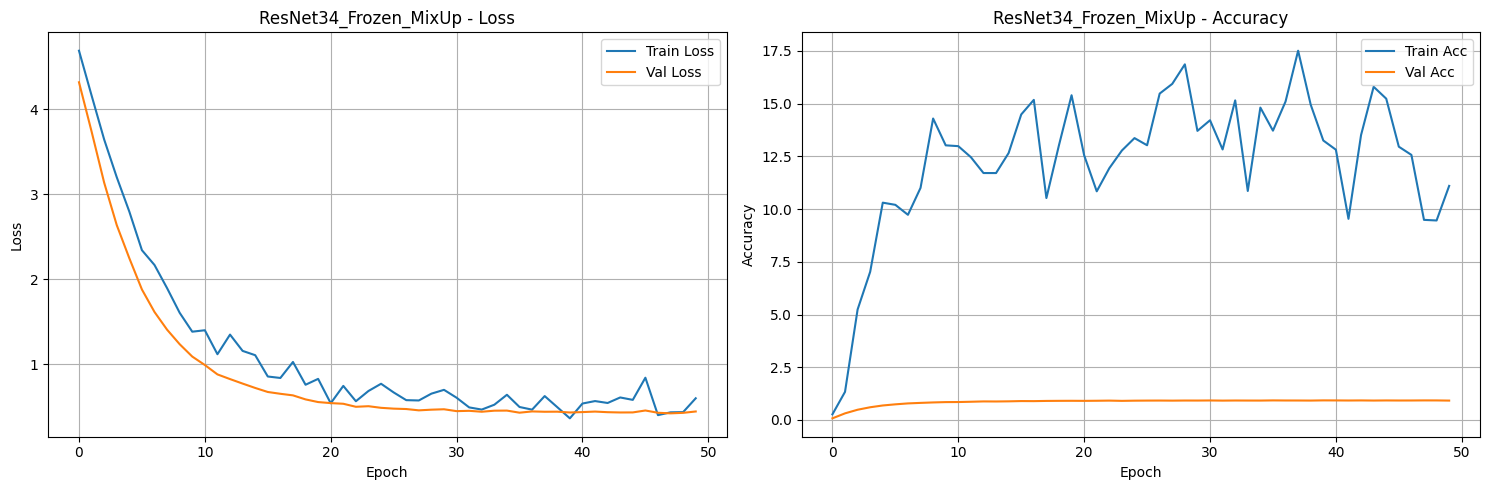

Evaluating on test set...


100%|██████████| 193/193 [00:35<00:00,  5.51it/s]

Test Loss: 0.5254
Test Accuracy: 0.8967

ResNet34 with MixUp - Test Accuracy: 0.8967


In [23]:
# Train ResNet-34 with MixUp augmentation
print("\n" + "="*70)
print("TRAINING RESNET-34 WITH MIXUP AUGMENTATION")
print("="*70)

model_resnet34_mixup = FlowerResNetFrozen(base_model='resnet34', num_frozen_stages=3, num_classes=102)
model_resnet34_mixup = model_resnet34_mixup.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define number of epochs (if not already defined)
num_epochs = 50

# Define optimizer
optimizer_34_mixup = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34_mixup.parameters()),
    lr=0.001, momentum=0.9
)
scheduler_34_mixup = lr_scheduler.StepLR(optimizer_34_mixup, step_size=30, gamma=0.1)

# Train model with MixUp
model_resnet34_mixup, train_losses_34_mixup, train_accs_34_mixup, val_losses_34_mixup, val_accs_34_mixup = train_model_with_mixup(
    model_resnet34_mixup, criterion, optimizer_34_mixup, scheduler_34_mixup, num_epochs, 'resnet34_frozen_mixup', alpha=0.2
)

# Plot results
plot_training_curves(train_losses_34_mixup, val_losses_34_mixup, train_accs_34_mixup, val_accs_34_mixup, 'ResNet34_Frozen_MixUp')

# Evaluate on test set
test_loss_34_mixup, test_acc_34_mixup, all_preds_34_mixup, all_labels_34_mixup = evaluate_model(model_resnet34_mixup, criterion)

# Save training logs
with open('resnet34_frozen_mixup.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(len(train_losses_34_mixup)):
        f.write(f"{epoch+1},{train_losses_34_mixup[epoch]:.4f},{val_losses_34_mixup[epoch]:.4f},{train_accs_34_mixup[epoch]:.4f},{val_accs_34_mixup[epoch]:.4f}\n")

print(f"\nResNet34 with MixUp - Test Accuracy: {test_acc_34_mixup:.4f}")


Mixup and Cutout: CutMix outperforms Mixup [46] by +5.51% and +1.41% on CUB200-2011 and ImageNet dataset, respectively. We observe that Mixup degraded the localization accuracy over baseline and tends to focus on a small region of image as shown in Fig- ure 4. As we hypothesized in Section 3.2, the Mixuped sample has the ambiguity, so the CNN trained with those samples tends to focus on the most discriminative part for classification, which leads the degradation of localization ability. 

https://wandb.ai/authors/tfaugmentation/reports/Modern-Data-Augmentation-Techniques-for-Computer-Vision--VmlldzoxNzU3NTU

----
## Improvement 2: Triplet Loss for Metric Learning
Implement Triplet Loss to improve feature discrimination and model robustness.


1. `TripletLoss` class - Implements metric learning loss:

    - Computes pairwise distances between embeddings
    - Uses hard negative mining to find most challenging examples
    - Loss: `L = max(0, d(anchor,positive) - d(anchor,negative) + margin)`

2. `ResNetWithTripletLoss` class - Modified ResNet architecture:

    - Removes final classification layer
    - Adds embedding projection layer (256-dim)
    - Adds separate classification head
    - Outputs both embeddings and logits

3. `train_model_with_triplet_loss()` function:

    - Key implementation (lines 143-162): Combined loss computation
        - Gets embeddings and logits from forward pass
        - Computes CE loss on logits
        - Computes Triplet loss on embeddings
        - Combined: `loss = 0.3 * triplet_loss + 0.7 * ce_loss`
    - Tracks triplet loss component separately for analysis

In [14]:
# ===== TRIPLET LOSS IMPLEMENTATION =====
class TripletLoss(nn.Module):
    """
    Triplet Loss: L = max(0, d(a,p) - d(a,n) + margin)

    Minimizes distance between anchor-positive pairs (same class)
    while maximizing distance between anchor-negative pairs (different classes)

    Reference: https://arxiv.org/abs/1503.03832
    """
    def __init__(self, margin=1.0, p=2):
        """
        Args:
            margin: margin for triplet loss
            p: p-norm to use for distance (2 for L2)
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.p = p

    def forward(self, embeddings, labels):
        """
        Compute triplet loss for a batch

        Args:
            embeddings: tensor of shape [B, D] - feature embeddings (before softmax)
            labels: tensor of shape [B] - class labels

        Returns:
            triplet_loss: scalar
        """
        batch_size = embeddings.size(0)

        # Compute pairwise distances: D_ij = ||e_i - e_j||_p
        distances = torch.cdist(embeddings, embeddings, p=self.p)  # [B, B]

        # Create masks for positive and negative pairs
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)  # [B, B]

        # Set diagonal to False (don't use same sample as positive)
        diag_mask = ~torch.eye(batch_size, dtype=torch.bool, device=labels.device)
        pos_mask = labels_equal & diag_mask  # Same class, different sample
        neg_mask = ~labels_equal  # Different class

        # For each anchor, find hardest positive and hardest negative
        distances_pos = distances.clone()
        distances_pos[~pos_mask] = float('-inf')  # Set invalid to -inf (take max)

        distances_neg = distances.clone()
        distances_neg[~neg_mask] = float('inf')   # Set invalid to +inf (take min)

        # Get hardest examples per anchor (hard negative mining)
        hardest_pos_dist, _ = distances_pos.max(dim=1)  # [B]
        hardest_neg_dist, _ = distances_neg.min(dim=1)  # [B]

        # Compute triplet loss
        triplet_losses = F.relu(hardest_pos_dist - hardest_neg_dist + self.margin)

        return triplet_losses.mean()


class ResNetWithTripletLoss(nn.Module):
    """
    ResNet model that outputs both classification logits and embedding features
    for use with triplet loss
    """
    def __init__(self, base_model='resnet34', num_frozen_stages=3, num_classes=102, embedding_dim=256):
        super(ResNetWithTripletLoss, self).__init__()

        if base_model == 'resnet34':
            self.backbone = models.resnet34(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Unsupported base model")

        # Freeze specified stages
        self._freeze_stages(num_frozen_stages)

        # Get feature dimension
        in_features = self.backbone.fc.in_features

        # Replace final layer with embedding layer
        self.backbone.fc = nn.Identity()  # Remove final classification layer

        # Add embedding projection layer
        self.embedding_proj = nn.Linear(in_features, embedding_dim)

        # Add classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def _freeze_stages(self, num_stages):
        """Freeze the first num_stages of ResNet"""
        if num_stages >= 1:
            for param in self.backbone.conv1.parameters():
                param.requires_grad = False
            for param in self.backbone.bn1.parameters():
                param.requires_grad = False
        if num_stages >= 2:
            for param in self.backbone.layer1.parameters():
                param.requires_grad = False
        if num_stages >= 3:
            for param in self.backbone.layer2.parameters():
                param.requires_grad = False
        if num_stages >= 4:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        if num_stages >= 5:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Get backbone features
        features = self.backbone(x)  # [B, 512]

        # Project to embedding space
        embeddings = self.embedding_proj(features)  # [B, 256]

        # Classification logits
        logits = self.classifier(embeddings)  # [B, 102]

        return embeddings, logits


def train_model_with_triplet_loss(model, criterion_ce, criterion_triplet, optimizer, scheduler,
                                  num_epochs=25, model_name='resnet_triplet', lambda_triplet=0.3):
    """
    Train model with combined Triplet Loss + Classification Loss
    Total Loss = lambda_triplet * triplet_loss + (1 - lambda_triplet) * ce_loss
    """
    since = time.time()

    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')

    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)

    # Track metrics
    train_losses, train_accs = [], []
    train_triplet_losses = []  # Track triplet loss component
    val_losses, val_accs = [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_triplet_loss = 0.0
            running_corrects = 0

            # Iterate over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # ===== TRIPLET LOSS (lines 143-162) =====
                    embeddings, logits = model(inputs)  # Get embeddings and logits
                    _, preds = torch.max(logits, 1)

                    # Compute classification loss
                    ce_loss = criterion_ce(logits, labels)

                    # Compute triplet loss on embeddings
                    tri_loss = criterion_triplet(embeddings, labels)

                    # Combined loss: weighted combination
                    loss = lambda_triplet * tri_loss + (1 - lambda_triplet) * ce_loss
                    # ===== END TRIPLET LOSS =====

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_triplet_loss += tri_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Triplet': f'{tri_loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_triplet_loss = running_triplet_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                print(f'{phase} Loss: {epoch_loss:.4f} (Triplet: {epoch_triplet_loss:.4f}) Acc: {epoch_acc:.4f}')
            else:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
                train_triplet_losses.append(epoch_triplet_loss)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_losses, train_accs, val_losses, val_accs, train_triplet_losses



TRAINING RESNET-34 WITH TRIPLET LOSS
ResNet34 Triplet - Trainable parameters: 20094310/21442214 (93.71%)
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, Loss=3.3319, Triplet=0.4327, Acc=0.0000]


train Loss: 3.3836 (Triplet: 0.3642) Acc: 0.0167


Val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, Loss=3.9573, Triplet=2.1341, Acc=0.0000]


val Loss: 3.8430 Acc: 0.0392
New best model saved with val_acc: 0.0392

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, Loss=3.2304, Triplet=0.3410, Acc=0.0000]


train Loss: 3.2607 (Triplet: 0.3722) Acc: 0.0422


Val Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s, Loss=3.7697, Triplet=1.9546, Acc=0.0000]


val Loss: 3.6902 Acc: 0.0990
New best model saved with val_acc: 0.0990

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, Loss=3.0104, Triplet=0.2603, Acc=0.1786]


train Loss: 3.1222 (Triplet: 0.3252) Acc: 0.1441


Val Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, Loss=3.4068, Triplet=1.6419, Acc=0.1429]


val Loss: 3.5231 Acc: 0.2265
New best model saved with val_acc: 0.2265

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, Loss=2.9487, Triplet=0.3351, Acc=0.2857]


train Loss: 3.0149 (Triplet: 0.3996) Acc: 0.2637


Val Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, Loss=3.1368, Triplet=1.3193, Acc=0.3571]


val Loss: 3.3373 Acc: 0.3441
New best model saved with val_acc: 0.3441

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s, Loss=2.9535, Triplet=0.4814, Acc=0.2500]


train Loss: 2.8433 (Triplet: 0.3006) Acc: 0.3853


Val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=2.8452, Triplet=1.0365, Acc=0.4643]


val Loss: 3.1519 Acc: 0.4314
New best model saved with val_acc: 0.4314

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s, Loss=2.8182, Triplet=0.2478, Acc=0.2500]


train Loss: 2.7086 (Triplet: 0.3350) Acc: 0.4725


Val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  4.93it/s, Loss=2.5417, Triplet=0.7828, Acc=0.5714]


val Loss: 2.9558 Acc: 0.4853
New best model saved with val_acc: 0.4853

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s, Loss=2.5969, Triplet=0.3573, Acc=0.4643]


train Loss: 2.5315 (Triplet: 0.2891) Acc: 0.5392


Val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s, Loss=2.2504, Triplet=0.6561, Acc=0.6786]


val Loss: 2.7673 Acc: 0.5686
New best model saved with val_acc: 0.5686

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=2.1586, Triplet=0.1936, Acc=0.6429]


train Loss: 2.3575 (Triplet: 0.2850) Acc: 0.6069


Val Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=1.9089, Triplet=0.4843, Acc=0.7143]


val Loss: 2.5790 Acc: 0.6039
New best model saved with val_acc: 0.6039

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, Loss=2.1820, Triplet=0.3646, Acc=0.5714]


train Loss: 2.1928 (Triplet: 0.3185) Acc: 0.6363


Val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s, Loss=1.6041, Triplet=0.4219, Acc=0.7500]


val Loss: 2.3999 Acc: 0.6363
New best model saved with val_acc: 0.6363

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, Loss=2.1666, Triplet=0.5612, Acc=0.6786]


train Loss: 2.0529 (Triplet: 0.3366) Acc: 0.6520


Val Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, Loss=1.4996, Triplet=0.4188, Acc=0.6786]


val Loss: 2.2337 Acc: 0.6784
New best model saved with val_acc: 0.6784

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s, Loss=1.7127, Triplet=0.2505, Acc=0.6786]


train Loss: 1.8482 (Triplet: 0.2556) Acc: 0.7098


Val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, Loss=1.3174, Triplet=0.4130, Acc=0.7857]


val Loss: 2.0778 Acc: 0.7078
New best model saved with val_acc: 0.7078

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, Loss=1.4068, Triplet=0.0318, Acc=0.9286]


train Loss: 1.7008 (Triplet: 0.2399) Acc: 0.7304


Val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, Loss=1.1234, Triplet=0.4094, Acc=0.7857]


val Loss: 1.9287 Acc: 0.7490
New best model saved with val_acc: 0.7490

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, Loss=1.5881, Triplet=0.1558, Acc=0.7143]


train Loss: 1.5563 (Triplet: 0.2724) Acc: 0.7637


Val Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, Loss=1.0280, Triplet=0.3548, Acc=0.8571]


val Loss: 1.7946 Acc: 0.7637
New best model saved with val_acc: 0.7637

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, Loss=1.4338, Triplet=0.1087, Acc=0.7500]


train Loss: 1.4144 (Triplet: 0.2584) Acc: 0.8196


Val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s, Loss=0.9608, Triplet=0.3462, Acc=0.8571]


val Loss: 1.6720 Acc: 0.7922
New best model saved with val_acc: 0.7922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=0.9939, Triplet=0.0884, Acc=0.9286]


train Loss: 1.2833 (Triplet: 0.2192) Acc: 0.8216


Val Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s, Loss=0.8097, Triplet=0.4146, Acc=0.8929]


val Loss: 1.5653 Acc: 0.8000
New best model saved with val_acc: 0.8000

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, Loss=1.1427, Triplet=0.2607, Acc=0.9643]


train Loss: 1.2099 (Triplet: 0.2856) Acc: 0.8265


Val Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=0.7655, Triplet=0.3815, Acc=0.8929]


val Loss: 1.4480 Acc: 0.8167
New best model saved with val_acc: 0.8167

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, Loss=0.8803, Triplet=0.0000, Acc=0.9286]


train Loss: 1.0823 (Triplet: 0.2072) Acc: 0.8618


Val Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=0.7013, Triplet=0.4057, Acc=0.9286]


val Loss: 1.3449 Acc: 0.8333
New best model saved with val_acc: 0.8333

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, Loss=0.9526, Triplet=0.0000, Acc=0.9286]


train Loss: 0.9501 (Triplet: 0.2022) Acc: 0.8833


Val Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=0.6491, Triplet=0.4001, Acc=0.8929]


val Loss: 1.2583 Acc: 0.8480
New best model saved with val_acc: 0.8480

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.7925, Triplet=0.0000, Acc=0.8571]


train Loss: 0.9081 (Triplet: 0.2473) Acc: 0.9010


Val Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, Loss=0.5951, Triplet=0.4534, Acc=0.9643]


val Loss: 1.1940 Acc: 0.8686
New best model saved with val_acc: 0.8686

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s, Loss=0.8564, Triplet=0.4829, Acc=0.9286]


train Loss: 0.8383 (Triplet: 0.1968) Acc: 0.8853


Val Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s, Loss=0.5194, Triplet=0.3764, Acc=0.9643]


val Loss: 1.1217 Acc: 0.8784
New best model saved with val_acc: 0.8784

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.7091, Triplet=0.0066, Acc=0.9286]


train Loss: 0.7558 (Triplet: 0.2181) Acc: 0.9010


Val Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.5042, Triplet=0.4359, Acc=0.9643]


val Loss: 1.0587 Acc: 0.8853
New best model saved with val_acc: 0.8853

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.6470, Triplet=0.0000, Acc=0.9643]


train Loss: 0.7140 (Triplet: 0.1941) Acc: 0.9039


Val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s, Loss=0.5375, Triplet=0.5023, Acc=0.9643]


val Loss: 1.0292 Acc: 0.8833

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s, Loss=0.7070, Triplet=0.4282, Acc=0.8929]


train Loss: 0.6392 (Triplet: 0.1903) Acc: 0.9157


Val Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, Loss=0.4970, Triplet=0.4651, Acc=0.9643]


val Loss: 0.9853 Acc: 0.8941
New best model saved with val_acc: 0.8941

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s, Loss=0.8268, Triplet=0.3415, Acc=0.8214]


train Loss: 0.6203 (Triplet: 0.2261) Acc: 0.9108


Val Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, Loss=0.4571, Triplet=0.4928, Acc=0.9643]


val Loss: 0.9333 Acc: 0.9000
New best model saved with val_acc: 0.9000

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s, Loss=0.5036, Triplet=0.0000, Acc=0.8929]


train Loss: 0.5744 (Triplet: 0.1442) Acc: 0.9176


Val Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, Loss=0.4547, Triplet=0.4848, Acc=0.9643]


val Loss: 0.8983 Acc: 0.9059
New best model saved with val_acc: 0.9059

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s, Loss=0.3024, Triplet=0.0000, Acc=0.9643]


train Loss: 0.4909 (Triplet: 0.1302) Acc: 0.9353


Val Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=0.4268, Triplet=0.4790, Acc=0.9643]


val Loss: 0.8807 Acc: 0.9069
New best model saved with val_acc: 0.9069

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, Loss=0.4336, Triplet=0.0313, Acc=1.0000]


train Loss: 0.4924 (Triplet: 0.1967) Acc: 0.9382


Val Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s, Loss=0.3950, Triplet=0.4360, Acc=0.9643]


val Loss: 0.8528 Acc: 0.9069

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, Loss=0.5070, Triplet=0.0941, Acc=0.8929]


train Loss: 0.4648 (Triplet: 0.1678) Acc: 0.9402


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s, Loss=0.4120, Triplet=0.4695, Acc=0.9286]


val Loss: 0.8144 Acc: 0.9059

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, Loss=0.5001, Triplet=0.2132, Acc=0.8929]


train Loss: 0.4297 (Triplet: 0.2014) Acc: 0.9471


Val Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=0.3740, Triplet=0.4400, Acc=0.9643]


val Loss: 0.8018 Acc: 0.9108
New best model saved with val_acc: 0.9108

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, Loss=0.3517, Triplet=0.0000, Acc=0.9286]


train Loss: 0.4254 (Triplet: 0.1516) Acc: 0.9422


Val Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s, Loss=0.3756, Triplet=0.4790, Acc=0.9643]


val Loss: 0.7894 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.2453, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3909 (Triplet: 0.1228) Acc: 0.9451


Val Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.3531, Triplet=0.4854, Acc=0.9643]


val Loss: 0.7819 Acc: 0.9127

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s, Loss=0.2071, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3769 (Triplet: 0.1142) Acc: 0.9431


Val Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, Loss=0.3800, Triplet=0.4632, Acc=0.9643]


val Loss: 0.7848 Acc: 0.9088

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, Loss=0.4722, Triplet=0.1933, Acc=0.9286]


train Loss: 0.3835 (Triplet: 0.1546) Acc: 0.9392


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, Loss=0.3464, Triplet=0.4476, Acc=0.9643]


val Loss: 0.7742 Acc: 0.9069

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s, Loss=0.3955, Triplet=0.0000, Acc=0.8929]


train Loss: 0.3710 (Triplet: 0.1332) Acc: 0.9490


Val Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=0.3513, Triplet=0.4368, Acc=0.9643]


val Loss: 0.7703 Acc: 0.9108

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s, Loss=0.2374, Triplet=0.0000, Acc=0.9286]


train Loss: 0.3718 (Triplet: 0.1381) Acc: 0.9588


Val Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s, Loss=0.3534, Triplet=0.4709, Acc=0.9643]


val Loss: 0.7679 Acc: 0.9147
New best model saved with val_acc: 0.9147

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s, Loss=0.3066, Triplet=0.0796, Acc=1.0000]


train Loss: 0.3468 (Triplet: 0.0930) Acc: 0.9500


Val Epoch 35: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.3379, Triplet=0.4275, Acc=0.9643]


val Loss: 0.7616 Acc: 0.9108

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, Loss=0.3884, Triplet=0.2315, Acc=0.9286]


train Loss: 0.3530 (Triplet: 0.1297) Acc: 0.9559


Val Epoch 36: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.3328, Triplet=0.4250, Acc=0.9643]


val Loss: 0.7612 Acc: 0.9147

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, Loss=0.7400, Triplet=0.7884, Acc=0.8929]


train Loss: 0.3672 (Triplet: 0.1615) Acc: 0.9471


Val Epoch 37: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, Loss=0.3598, Triplet=0.4737, Acc=0.9643]


val Loss: 0.7692 Acc: 0.9088

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, Loss=0.3275, Triplet=0.0606, Acc=0.9643]


train Loss: 0.3841 (Triplet: 0.1613) Acc: 0.9451


Val Epoch 38: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, Loss=0.3393, Triplet=0.4417, Acc=0.9643]


val Loss: 0.7563 Acc: 0.9147

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s, Loss=0.3504, Triplet=0.0000, Acc=0.8929]


train Loss: 0.3515 (Triplet: 0.1291) Acc: 0.9480


Val Epoch 39: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.3625, Triplet=0.4452, Acc=0.9643]


val Loss: 0.7563 Acc: 0.9167
New best model saved with val_acc: 0.9167

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, Loss=0.2744, Triplet=0.0000, Acc=0.9643]


train Loss: 0.3318 (Triplet: 0.0902) Acc: 0.9569


Val Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s, Loss=0.3367, Triplet=0.4026, Acc=0.9643]


val Loss: 0.7482 Acc: 0.9127

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s, Loss=0.3723, Triplet=0.0000, Acc=0.9286]


train Loss: 0.3345 (Triplet: 0.0953) Acc: 0.9480


Val Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.3565, Triplet=0.4360, Acc=0.9643]


val Loss: 0.7475 Acc: 0.9167

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, Loss=0.3930, Triplet=0.3833, Acc=0.9643]


train Loss: 0.3524 (Triplet: 0.1345) Acc: 0.9520


Val Epoch 42: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, Loss=0.3440, Triplet=0.4551, Acc=0.9643]


val Loss: 0.7526 Acc: 0.9118

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s, Loss=0.3324, Triplet=0.0440, Acc=0.8929]


train Loss: 0.3120 (Triplet: 0.0924) Acc: 0.9618


Val Epoch 43: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, Loss=0.3560, Triplet=0.4567, Acc=0.9643]


val Loss: 0.7476 Acc: 0.9157

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.3074, Triplet=0.1750, Acc=0.9643]


train Loss: 0.3362 (Triplet: 0.1560) Acc: 0.9549


Val Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, Loss=0.3502, Triplet=0.4431, Acc=0.9643]


val Loss: 0.7506 Acc: 0.9186
New best model saved with val_acc: 0.9186

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=0.2217, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3410 (Triplet: 0.1060) Acc: 0.9471


Val Epoch 45: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, Loss=0.3330, Triplet=0.4207, Acc=0.9643]


val Loss: 0.7454 Acc: 0.9176

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, Loss=0.3414, Triplet=0.1192, Acc=0.9643]


train Loss: 0.3262 (Triplet: 0.0945) Acc: 0.9549


Val Epoch 46: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.3371, Triplet=0.4500, Acc=0.9643]


val Loss: 0.7482 Acc: 0.9167

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, Loss=0.3032, Triplet=0.0144, Acc=0.9643]


train Loss: 0.3311 (Triplet: 0.0940) Acc: 0.9451


Val Epoch 47: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, Loss=0.3387, Triplet=0.4377, Acc=0.9643]


val Loss: 0.7422 Acc: 0.9167

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, Loss=0.2946, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3445 (Triplet: 0.1299) Acc: 0.9500


Val Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, Loss=0.3365, Triplet=0.4485, Acc=0.9643]


val Loss: 0.7484 Acc: 0.9167

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s, Loss=0.2116, Triplet=0.0000, Acc=0.9643]


train Loss: 0.3601 (Triplet: 0.1345) Acc: 0.9480


Val Epoch 49: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, Loss=0.3275, Triplet=0.4286, Acc=0.9643]


val Loss: 0.7376 Acc: 0.9176

Training complete in 9m 50s
Best val Acc: 0.918627


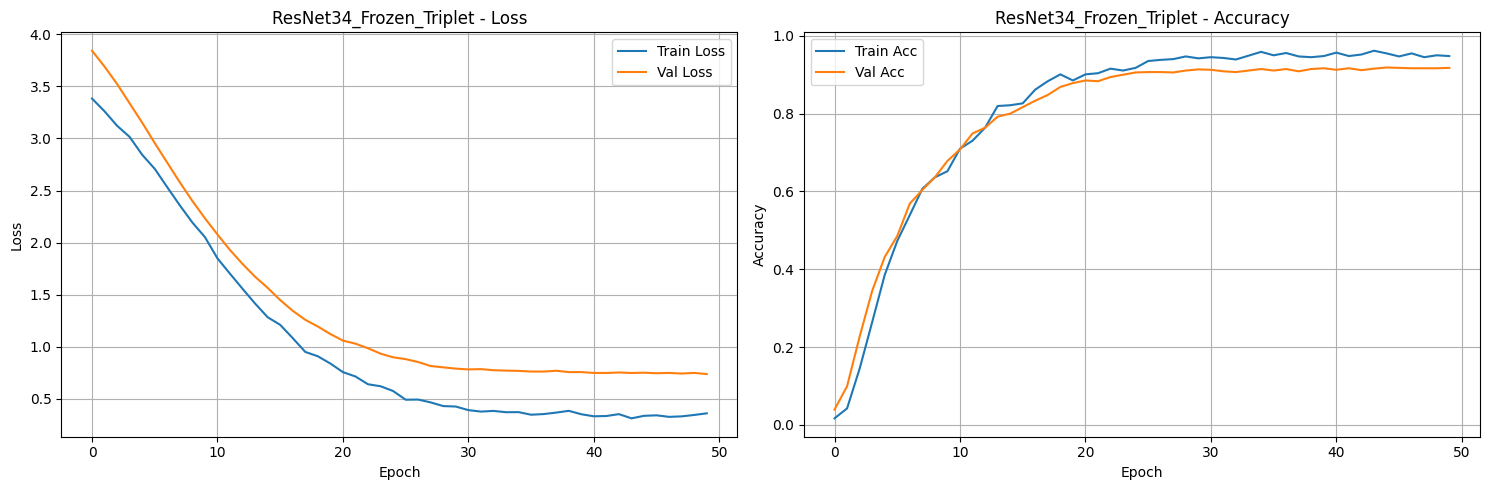

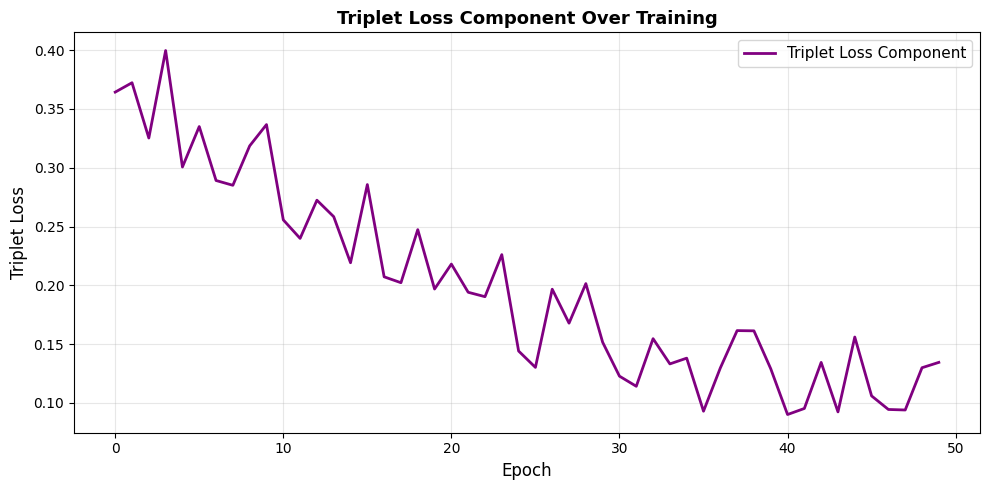

Evaluating on test set...


100%|██████████| 193/193 [00:34<00:00,  5.59it/s]

Test Loss: 0.6260
Test Accuracy: 0.8858

ResNet34 with Triplet Loss - Test Accuracy: 0.8858


In [19]:
# Train ResNet-34 with Triplet Loss
print("\n" + "="*70)
print("TRAINING RESNET-34 WITH TRIPLET LOSS")
print("="*70)

# Create model with triplet loss support
model_resnet34_triplet = ResNetWithTripletLoss(base_model='resnet34', num_frozen_stages=3, num_classes=102, embedding_dim=256)
model_resnet34_triplet = model_resnet34_triplet.to(device)

# Count parameters
trainable_params_triplet = sum(p.numel() for p in model_resnet34_triplet.parameters() if p.requires_grad)
total_params_triplet = sum(p.numel() for p in model_resnet34_triplet.parameters())
print(f"ResNet34 Triplet - Trainable parameters: {trainable_params_triplet}/{total_params_triplet} ({trainable_params_triplet/total_params_triplet*100:.2f}%)")

# Define loss functions
criterion_ce = nn.CrossEntropyLoss()
criterion_triplet = TripletLoss(margin=1.0, p=2)

# Define optimizer
optimizer_34_triplet = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34_triplet.parameters()),
    lr=0.001, momentum=0.9
)
scheduler_34_triplet = lr_scheduler.StepLR(optimizer_34_triplet, step_size=30, gamma=0.1)

# Train model with Triplet Loss
model_resnet34_triplet, train_losses_34_triplet, train_accs_34_triplet, val_losses_34_triplet, val_accs_34_triplet, train_triplet_losses_34 = train_model_with_triplet_loss(
    model_resnet34_triplet, criterion_ce, criterion_triplet, optimizer_34_triplet, scheduler_34_triplet,
    num_epochs, 'resnet34_frozen_triplet', lambda_triplet=0.3
)

# Plot results
plot_training_curves(train_losses_34_triplet, val_losses_34_triplet, train_accs_34_triplet, val_accs_34_triplet, 'ResNet34_Frozen_Triplet')

# Plot triplet loss component
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_triplet_losses_34, label='Triplet Loss Component', linewidth=2, color='purple')
ax.set_title('Triplet Loss Component Over Training', fontsize=13, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Triplet Loss', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resnet34_frozen_triplet_loss_component.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate on test set - Wrapper to handle tuple output from ResNetWithTripletLoss
was_training = model_resnet34_triplet.training
model_resnet34_triplet.eval()

test_loss_34_triplet = 0.0
correct = 0
all_preds_34_triplet = []
all_labels_34_triplet = []

print("Evaluating on test set...")
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings, logits = model_resnet34_triplet(inputs)  # Get both embeddings and logits
        _, preds = torch.max(logits, 1)

        test_loss_34_triplet += criterion_ce(logits, labels).item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

        all_preds_34_triplet.extend(preds.cpu().numpy())
        all_labels_34_triplet.extend(labels.cpu().numpy())

test_loss_34_triplet /= dataset_sizes['test']
test_acc_34_triplet = correct.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss_34_triplet:.4f}')
print(f'Test Accuracy: {test_acc_34_triplet:.4f}')

model_resnet34_triplet.train(mode=was_training)

# Save training logs
with open('resnet34_frozen_triplet.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc,Train_Triplet_Loss\n")
    for epoch in range(len(train_losses_34_triplet)):
        f.write(f"{epoch+1},{train_losses_34_triplet[epoch]:.4f},{val_losses_34_triplet[epoch]:.4f},{train_accs_34_triplet[epoch]:.4f},{val_accs_34_triplet[epoch]:.4f},{train_triplet_losses_34[epoch]:.4f}\n")

print(f"\nResNet34 with Triplet Loss - Test Accuracy: {test_acc_34_triplet:.4f}")




In [21]:
# Comparison of all methods
print("\n" + "="*70)
print("COMPARISON: Baseline vs MixUp vs Triplet Loss")
print("="*70)
print(f"{'Method':<40} {'Test Accuracy':<20}")
print("-"*70)
#print(f"{'ResNet34 Frozen (Baseline)':<40} {test_acc_34:.4f}")
print(f"{'ResNet34 Frozen + MixUp':<40} {test_acc_34_mixup:.4f}")
print(f"{'ResNet34 Frozen + Triplet Loss':<40} {test_acc_34_triplet:.4f}")
print("="*70)


COMPARISON: Baseline vs MixUp vs Triplet Loss
Method                                   Test Accuracy       
----------------------------------------------------------------------
ResNet34 Frozen + MixUp                  0.8969
ResNet34 Frozen + Triplet Loss           0.8858


old


TRAINING RESNET-34 WITH TRIPLET LOSS
ResNet34 Triplet - Trainable parameters: 20094310/21442214 (93.71%)
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=3.4305, Triplet=0.6556, Acc=0.0000]


train Loss: 3.3691 (Triplet: 0.3512) Acc: 0.0147


Val Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, Loss=3.7495, Triplet=2.2827, Acc=0.0357]


val Loss: 3.8194 Acc: 0.0176
New best model saved with val_acc: 0.0176

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, Loss=3.1817, Triplet=0.0174, Acc=0.0357]


train Loss: 3.2690 (Triplet: 0.4161) Acc: 0.0382


Val Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=3.5890, Triplet=2.0534, Acc=0.0714]


val Loss: 3.6631 Acc: 0.0696
New best model saved with val_acc: 0.0696

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s, Loss=3.0232, Triplet=0.0601, Acc=0.1071]


train Loss: 3.1117 (Triplet: 0.2997) Acc: 0.1127


Val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=3.3845, Triplet=1.8305, Acc=0.3929]


val Loss: 3.4943 Acc: 0.2127
New best model saved with val_acc: 0.2127

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, Loss=3.1217, Triplet=0.5764, Acc=0.2500]


train Loss: 2.9885 (Triplet: 0.3093) Acc: 0.2490


Val Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s, Loss=3.1821, Triplet=1.5378, Acc=0.3571]


val Loss: 3.3018 Acc: 0.3588
New best model saved with val_acc: 0.3588

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, Loss=2.7942, Triplet=0.3437, Acc=0.3929]


train Loss: 2.8403 (Triplet: 0.3024) Acc: 0.3647


Val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, Loss=2.9436, Triplet=1.2823, Acc=0.3929]


val Loss: 3.1066 Acc: 0.4412
New best model saved with val_acc: 0.4412

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s, Loss=2.7397, Triplet=0.4576, Acc=0.4643]


train Loss: 2.6922 (Triplet: 0.3546) Acc: 0.4745


Val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=2.7150, Triplet=1.2143, Acc=0.5714]


val Loss: 2.9118 Acc: 0.5275
New best model saved with val_acc: 0.5275

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Loss=2.5440, Triplet=0.2762, Acc=0.4286]


train Loss: 2.5208 (Triplet: 0.2922) Acc: 0.5304


Val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, Loss=2.4562, Triplet=1.0760, Acc=0.6786]


val Loss: 2.7168 Acc: 0.5667
New best model saved with val_acc: 0.5667

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, Loss=2.0198, Triplet=0.0423, Acc=0.7500]


train Loss: 2.3093 (Triplet: 0.2428) Acc: 0.6167


Val Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=2.1321, Triplet=0.8448, Acc=0.7857]


val Loss: 2.5286 Acc: 0.6333
New best model saved with val_acc: 0.6333

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s, Loss=2.1380, Triplet=0.7507, Acc=0.7143]


train Loss: 2.1567 (Triplet: 0.2757) Acc: 0.6422


Val Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=1.8906, Triplet=0.8187, Acc=0.8214]


val Loss: 2.3681 Acc: 0.6578
New best model saved with val_acc: 0.6578

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, Loss=2.0661, Triplet=0.4187, Acc=0.6786]


train Loss: 1.9837 (Triplet: 0.2601) Acc: 0.6804


Val Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s, Loss=1.6860, Triplet=0.7886, Acc=0.8571]


val Loss: 2.1945 Acc: 0.6902
New best model saved with val_acc: 0.6902

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s, Loss=1.8626, Triplet=0.1515, Acc=0.7143]


train Loss: 1.8462 (Triplet: 0.2839) Acc: 0.7010


Val Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s, Loss=1.4979, Triplet=0.7841, Acc=0.8571]


val Loss: 2.0416 Acc: 0.7186
New best model saved with val_acc: 0.7186

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s, Loss=1.2577, Triplet=0.0000, Acc=0.9643]


train Loss: 1.7073 (Triplet: 0.3228) Acc: 0.7549


Val Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, Loss=1.2689, Triplet=0.6911, Acc=0.8571]


val Loss: 1.9001 Acc: 0.7441
New best model saved with val_acc: 0.7441

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, Loss=1.4516, Triplet=0.0242, Acc=0.7500]


train Loss: 1.5353 (Triplet: 0.2358) Acc: 0.7882


Val Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=1.1956, Triplet=0.7265, Acc=0.8571]


val Loss: 1.7688 Acc: 0.7578
New best model saved with val_acc: 0.7578

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s, Loss=1.5706, Triplet=0.6959, Acc=0.7857]


train Loss: 1.4233 (Triplet: 0.2616) Acc: 0.7873


Val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=1.0454, Triplet=0.6183, Acc=0.8571]


val Loss: 1.6468 Acc: 0.7873
New best model saved with val_acc: 0.7873

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=1.4406, Triplet=0.0081, Acc=0.7143]


train Loss: 1.2962 (Triplet: 0.2721) Acc: 0.8196


Val Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, Loss=0.9488, Triplet=0.5692, Acc=0.8571]


val Loss: 1.5378 Acc: 0.8078
New best model saved with val_acc: 0.8078

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s, Loss=1.1000, Triplet=0.1077, Acc=0.8214]


train Loss: 1.1631 (Triplet: 0.2592) Acc: 0.8471


Val Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s, Loss=0.9126, Triplet=0.4828, Acc=0.8571]


val Loss: 1.4351 Acc: 0.8176
New best model saved with val_acc: 0.8176

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s, Loss=1.3997, Triplet=0.7143, Acc=0.8214]


train Loss: 1.0821 (Triplet: 0.2347) Acc: 0.8637


Val Epoch 16: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s, Loss=0.7747, Triplet=0.4810, Acc=0.8571]


val Loss: 1.3348 Acc: 0.8304
New best model saved with val_acc: 0.8304

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s, Loss=0.9541, Triplet=0.0000, Acc=0.8929]


train Loss: 0.9827 (Triplet: 0.2360) Acc: 0.8755


Val Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.7393, Triplet=0.5259, Acc=0.8571]


val Loss: 1.2482 Acc: 0.8510
New best model saved with val_acc: 0.8510

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, Loss=0.8729, Triplet=0.0000, Acc=0.8929]


train Loss: 0.9323 (Triplet: 0.2984) Acc: 0.8853


Val Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=0.6884, Triplet=0.4587, Acc=0.8929]


val Loss: 1.1711 Acc: 0.8598
New best model saved with val_acc: 0.8598

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s, Loss=0.6435, Triplet=0.0000, Acc=0.9643]


train Loss: 0.8376 (Triplet: 0.2111) Acc: 0.8882


Val Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s, Loss=0.7028, Triplet=0.5093, Acc=0.9286]


val Loss: 1.0942 Acc: 0.8686
New best model saved with val_acc: 0.8686

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s, Loss=0.8221, Triplet=0.2392, Acc=0.9286]


train Loss: 0.7539 (Triplet: 0.1818) Acc: 0.9020


Val Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.6635, Triplet=0.4300, Acc=0.9286]


val Loss: 1.0513 Acc: 0.8647

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s, Loss=0.7107, Triplet=0.1870, Acc=0.8214]


train Loss: 0.6991 (Triplet: 0.1901) Acc: 0.9196


Val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, Loss=0.6502, Triplet=0.5258, Acc=0.9286]


val Loss: 0.9985 Acc: 0.8775
New best model saved with val_acc: 0.8775

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.5785, Triplet=0.1623, Acc=0.8929]


train Loss: 0.6576 (Triplet: 0.2231) Acc: 0.9127


Val Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, Loss=0.5349, Triplet=0.3850, Acc=0.9643]


val Loss: 0.9462 Acc: 0.8902
New best model saved with val_acc: 0.8902

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, Loss=0.4637, Triplet=0.0199, Acc=1.0000]


train Loss: 0.6129 (Triplet: 0.1955) Acc: 0.9147


Val Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.53it/s, Loss=0.5311, Triplet=0.3729, Acc=1.0000]


val Loss: 0.9165 Acc: 0.8951
New best model saved with val_acc: 0.8951

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.3310, Triplet=0.0000, Acc=0.9643]


train Loss: 0.5507 (Triplet: 0.1650) Acc: 0.9275


Val Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, Loss=0.4894, Triplet=0.3972, Acc=0.9643]


val Loss: 0.8837 Acc: 0.8951

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s, Loss=0.3784, Triplet=0.0556, Acc=0.9643]


train Loss: 0.5223 (Triplet: 0.1415) Acc: 0.9235


Val Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s, Loss=0.4876, Triplet=0.3629, Acc=0.9286]


val Loss: 0.8396 Acc: 0.9039
New best model saved with val_acc: 0.9039

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  5.00it/s, Loss=0.3178, Triplet=0.0000, Acc=0.9643]


train Loss: 0.5005 (Triplet: 0.1578) Acc: 0.9225


Val Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=0.4499, Triplet=0.3777, Acc=1.0000]


val Loss: 0.8204 Acc: 0.9000

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, Loss=0.5044, Triplet=0.0068, Acc=0.9286]


train Loss: 0.4952 (Triplet: 0.1701) Acc: 0.9245


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s, Loss=0.4198, Triplet=0.2841, Acc=1.0000]


val Loss: 0.7951 Acc: 0.9059
New best model saved with val_acc: 0.9059

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, Loss=0.2622, Triplet=0.0000, Acc=1.0000]


train Loss: 0.4521 (Triplet: 0.1749) Acc: 0.9412


Val Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, Loss=0.4052, Triplet=0.2255, Acc=0.8929]


val Loss: 0.7590 Acc: 0.9039

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s, Loss=0.3760, Triplet=0.1989, Acc=0.9643]


train Loss: 0.4068 (Triplet: 0.1678) Acc: 0.9500


Val Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.3918, Triplet=0.2948, Acc=0.9643]


val Loss: 0.7330 Acc: 0.9098
New best model saved with val_acc: 0.9098

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, Loss=0.4486, Triplet=0.0000, Acc=0.8571]


train Loss: 0.3918 (Triplet: 0.0706) Acc: 0.9402


Val Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s, Loss=0.4369, Triplet=0.4350, Acc=0.9643]


val Loss: 0.7322 Acc: 0.9078

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, Loss=0.3631, Triplet=0.1095, Acc=0.9286]


train Loss: 0.3980 (Triplet: 0.1821) Acc: 0.9480


Val Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, Loss=0.4110, Triplet=0.3522, Acc=1.0000]


val Loss: 0.7296 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, Loss=0.2187, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3900 (Triplet: 0.1404) Acc: 0.9422


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s, Loss=0.3734, Triplet=0.2377, Acc=1.0000]


val Loss: 0.7290 Acc: 0.9108

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, Loss=0.4168, Triplet=0.2036, Acc=1.0000]


train Loss: 0.3745 (Triplet: 0.1012) Acc: 0.9510


Val Epoch 33: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, Loss=0.4249, Triplet=0.3495, Acc=0.9643]


val Loss: 0.7277 Acc: 0.9088

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, Loss=0.6295, Triplet=0.4389, Acc=0.8929]


train Loss: 0.4162 (Triplet: 0.1711) Acc: 0.9333


Val Epoch 34: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s, Loss=0.4138, Triplet=0.3602, Acc=0.9643]


val Loss: 0.7249 Acc: 0.9088

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, Loss=0.3543, Triplet=0.0631, Acc=0.9643]


train Loss: 0.3614 (Triplet: 0.1018) Acc: 0.9471


Val Epoch 35: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, Loss=0.3745, Triplet=0.2685, Acc=1.0000]


val Loss: 0.7249 Acc: 0.9118

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, Loss=0.1871, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3742 (Triplet: 0.1287) Acc: 0.9510


Val Epoch 36: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.3899, Triplet=0.3400, Acc=1.0000]


val Loss: 0.7215 Acc: 0.9098

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, Loss=0.4059, Triplet=0.2050, Acc=0.8929]


train Loss: 0.3419 (Triplet: 0.0984) Acc: 0.9529


Val Epoch 37: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Loss=0.3675, Triplet=0.2909, Acc=1.0000]


val Loss: 0.7218 Acc: 0.9078

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, Loss=0.2287, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3452 (Triplet: 0.0855) Acc: 0.9598


Val Epoch 38: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, Loss=0.3747, Triplet=0.2610, Acc=0.9643]


val Loss: 0.7191 Acc: 0.9118

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, Loss=0.2881, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3349 (Triplet: 0.1033) Acc: 0.9627


Val Epoch 39: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s, Loss=0.4130, Triplet=0.3683, Acc=0.9643]


val Loss: 0.7138 Acc: 0.9098

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s, Loss=0.2612, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3240 (Triplet: 0.0809) Acc: 0.9647


Val Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  4.89it/s, Loss=0.4062, Triplet=0.3913, Acc=1.0000]


val Loss: 0.7135 Acc: 0.9167
New best model saved with val_acc: 0.9167

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Loss=0.3468, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3510 (Triplet: 0.1249) Acc: 0.9539


Val Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  4.89it/s, Loss=0.3757, Triplet=0.3214, Acc=1.0000]


val Loss: 0.7125 Acc: 0.9167

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, Loss=0.2960, Triplet=0.0000, Acc=0.9286]


train Loss: 0.3750 (Triplet: 0.1345) Acc: 0.9431


Val Epoch 42: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s, Loss=0.3638, Triplet=0.3200, Acc=1.0000]


val Loss: 0.7140 Acc: 0.9118

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s, Loss=0.4168, Triplet=0.2701, Acc=1.0000]


train Loss: 0.3437 (Triplet: 0.1262) Acc: 0.9539


Val Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, Loss=0.3859, Triplet=0.3099, Acc=0.9643]


val Loss: 0.7083 Acc: 0.9088

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, Loss=0.2523, Triplet=0.0000, Acc=0.9286]


train Loss: 0.3177 (Triplet: 0.1097) Acc: 0.9647


Val Epoch 44: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s, Loss=0.3899, Triplet=0.3030, Acc=1.0000]


val Loss: 0.7128 Acc: 0.9186
New best model saved with val_acc: 0.9186

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.2635, Triplet=0.0000, Acc=1.0000]


train Loss: 0.3363 (Triplet: 0.0945) Acc: 0.9588


Val Epoch 45: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s, Loss=0.3900, Triplet=0.3524, Acc=1.0000]


val Loss: 0.7036 Acc: 0.9176

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, Loss=0.4816, Triplet=0.2060, Acc=0.9286]


train Loss: 0.3495 (Triplet: 0.1228) Acc: 0.9598


Val Epoch 46: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, Loss=0.3953, Triplet=0.3269, Acc=0.9643]


val Loss: 0.7071 Acc: 0.9157

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, Loss=0.2787, Triplet=0.0728, Acc=1.0000]


train Loss: 0.3777 (Triplet: 0.1865) Acc: 0.9480


Val Epoch 47: 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, Loss=0.3812, Triplet=0.3070, Acc=1.0000]


val Loss: 0.7065 Acc: 0.9118

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, Loss=0.4713, Triplet=0.4904, Acc=0.9286]


train Loss: 0.3432 (Triplet: 0.1374) Acc: 0.9520


Val Epoch 48: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, Loss=0.3661, Triplet=0.2941, Acc=0.9643]


val Loss: 0.7099 Acc: 0.9176

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, Loss=0.3088, Triplet=0.0000, Acc=0.9286]


train Loss: 0.3370 (Triplet: 0.1329) Acc: 0.9510


Val Epoch 49: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s, Loss=0.3586, Triplet=0.2514, Acc=0.9643]


val Loss: 0.7045 Acc: 0.9127

Training complete in 9m 52s
Best val Acc: 0.918627


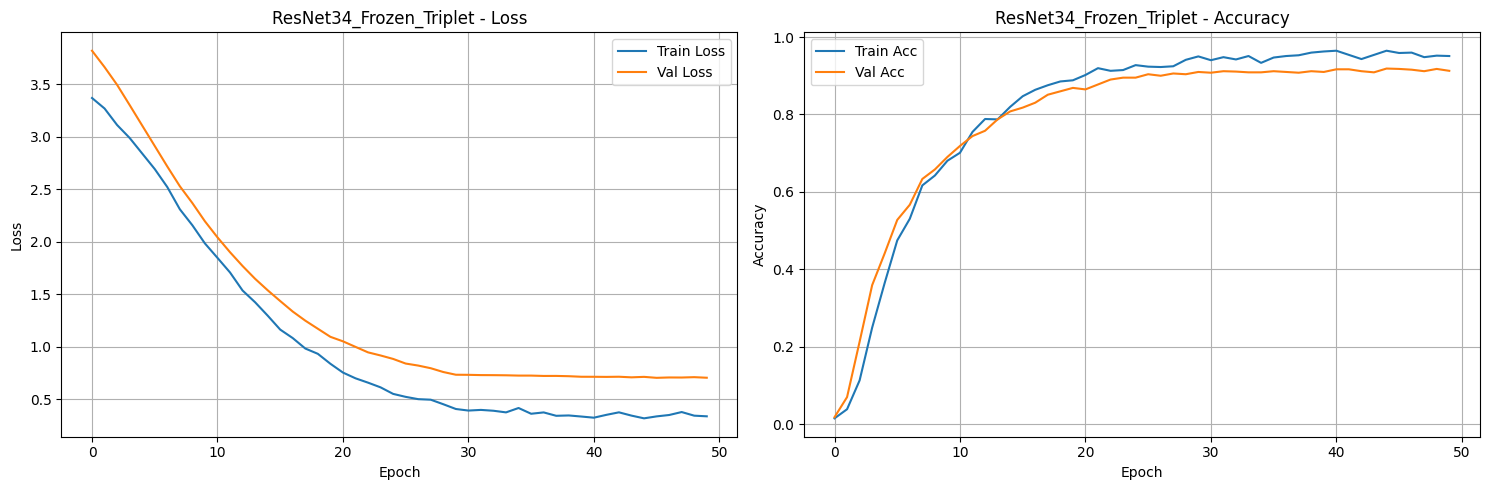

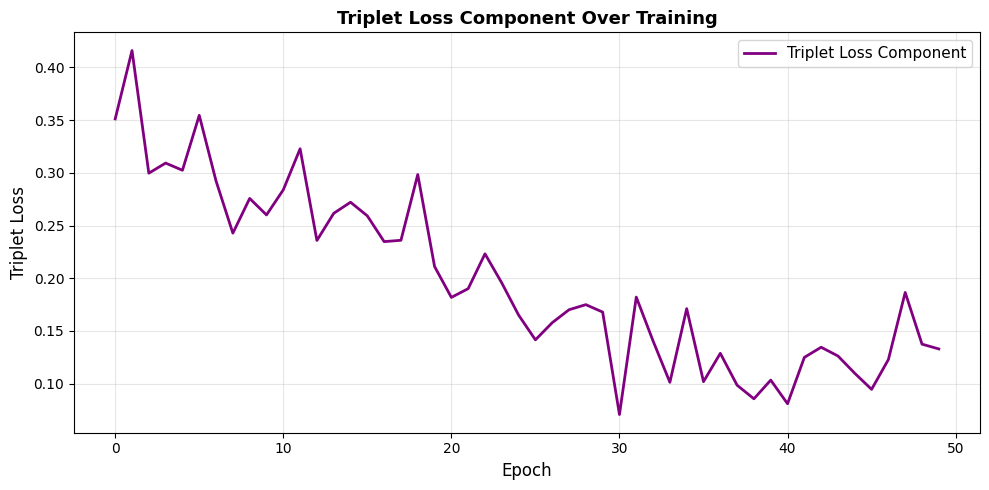

Evaluating on test set...


  0%|          | 0/193 [00:00<?, ?it/s]


TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


In [15]:
# Train ResNet-34 with Triplet Loss
print("\n" + "="*70)
print("TRAINING RESNET-34 WITH TRIPLET LOSS")
print("="*70)

# Create model with triplet loss support
model_resnet34_triplet = ResNetWithTripletLoss(base_model='resnet34', num_frozen_stages=3, num_classes=102, embedding_dim=256)
model_resnet34_triplet = model_resnet34_triplet.to(device)

# Count parameters
trainable_params_triplet = sum(p.numel() for p in model_resnet34_triplet.parameters() if p.requires_grad)
total_params_triplet = sum(p.numel() for p in model_resnet34_triplet.parameters())
print(f"ResNet34 Triplet - Trainable parameters: {trainable_params_triplet}/{total_params_triplet} ({trainable_params_triplet/total_params_triplet*100:.2f}%)")

# Define loss functions
criterion_ce = nn.CrossEntropyLoss()
criterion_triplet = TripletLoss(margin=1.0, p=2)

# Define optimizer
optimizer_34_triplet = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34_triplet.parameters()),
    lr=0.001, momentum=0.9
)
scheduler_34_triplet = lr_scheduler.StepLR(optimizer_34_triplet, step_size=30, gamma=0.1)

# Train model with Triplet Loss
model_resnet34_triplet, train_losses_34_triplet, train_accs_34_triplet, val_losses_34_triplet, val_accs_34_triplet, train_triplet_losses_34 = train_model_with_triplet_loss(
    model_resnet34_triplet, criterion_ce, criterion_triplet, optimizer_34_triplet, scheduler_34_triplet,
    num_epochs, 'resnet34_frozen_triplet', lambda_triplet=0.3
)




In [18]:
test_loss_34_triplet, test_acc_34_triplet, all_preds_34_triplet, all_labels_34_triplet = evaluate_model(model_resnet34_triplet, criterion_ce)


Evaluating on test set...


  0%|          | 0/193 [00:03<?, ?it/s]


TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


In [17]:
# Plot results
plot_training_curves(train_losses_34_triplet, val_losses_34_triplet, train_accs_34_triplet, val_accs_34_triplet, 'ResNet34_Frozen_Triplet')

# Plot triplet loss component
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_triplet_losses_34, label='Triplet Loss Component', linewidth=2, color='purple')
ax.set_title('Triplet Loss Component Over Training', fontsize=13, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Triplet Loss', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resnet34_frozen_triplet_loss_component.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate on test set
test_loss_34_triplet, test_acc_34_triplet, all_preds_34_triplet, all_labels_34_triplet = evaluate_model(model_resnet34_triplet, criterion_ce)

# Save training logs
with open('resnet34_frozen_triplet.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc,Train_Triplet_Loss\n")
    for epoch in range(len(train_losses_34_triplet)):
        f.write(f"{epoch+1},{train_losses_34_triplet[epoch]:.4f},{val_losses_34_triplet[epoch]:.4f},{train_accs_34_triplet[epoch]:.4f},{val_accs_34_triplet[epoch]:.4f},{train_triplet_losses_34[epoch]:.4f}\n")

print(f"\nResNet34 with Triplet Loss - Test Accuracy: {test_acc_34_triplet:.4f}")

# Comparison of all methods
print("\n" + "="*70)
print("COMPARISON: Baseline vs MixUp vs Triplet Loss")
print("="*70)
print(f"{'Method':<40} {'Test Accuracy':<20}")
print("-"*70)
print(f"{'ResNet34 Frozen (Baseline)':<40} {test_acc_34:.4f}")
print(f"{'ResNet34 Frozen + MixUp':<40} {test_acc_34_mixup:.4f}")
print(f"{'ResNet34 Frozen + Triplet Loss':<40} {test_acc_34_triplet:.4f}")
print("="*70)

Evaluating on test set...


100%|██████████| 193/193 [00:34<00:00,  5.53it/s]


Test Loss: 0.6401
Test Accuracy: 0.8777

ResNet34 with Triplet Loss - Test Accuracy: 0.8777

COMPARISON: Baseline vs MixUp vs Triplet Loss
Method                                   Test Accuracy       
----------------------------------------------------------------------


NameError: name 'test_acc_34' is not defined

In [ ]:
# Special evaluation function for Triplet Loss model
def evaluate_model_triplet(model, criterion):
    was_training = model.training
    model.eval()

    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            embeddings, logits = model(inputs)  # Get both embeddings and logits
            _, preds = torch.max(logits, 1)

            test_loss += criterion(logits, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

# Re-evaluate using the correct function
test_loss_34_triplet, test_acc_34_triplet, all_preds_34_triplet, all_labels_34_triplet = evaluate_model_triplet(model_resnet34_triplet, criterion_ce)

# Save training logs
with open('resnet34_frozen_triplet.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc,Train_Triplet_Loss\n")
    for epoch in range(len(train_losses_34_triplet)):
        f.write(f"{epoch+1},{train_losses_34_triplet[epoch]:.4f},{val_losses_34_triplet[epoch]:.4f},{train_accs_34_triplet[epoch]:.4f},{val_accs_34_triplet[epoch]:.4f},{train_triplet_losses_34[epoch]:.4f}\n")

print(f"\nResNet34 with Triplet Loss - Test Accuracy: {test_acc_34_triplet:.4f}")

# Comparison of all methods
print("\n" + "="*70)
print("COMPARISON: Baseline vs MixUp vs Triplet Loss")
print("="*70)
print(f"{'Method':<40} {'Test Accuracy':<20}")
print("-"*70)
print(f"{'ResNet34 Frozen (Baseline)':<40} {test_acc_34:.4f}")
print(f"{'ResNet34 Frozen + MixUp':<40} {test_acc_34_mixup:.4f}")
print(f"{'ResNet34 Frozen + Triplet Loss':<40} {test_acc_34_triplet:.4f}")
print("="*70)
